In [2]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import powerlaw

In [190]:
def mean_degree(g):
    degree = g.degree_distribution()
    
    return degree.mean

def mean_dist_node_pairs(g):
    return


def exp_power_law_degrees(g):
    degrees = g.degree(g.vs)
    fitted = ig.statistics.power_law_fit(degrees)
    
    return fitted.alpha, fitted.xmin, fitted.p

def exp_power_law_alternative(g):
    degrees = g.degree(g.vs)
    results = powerlaw.Fit(data)
    
    return results.power_law.alpha, results.power_law.xmin

def exp_power_law_strengths(g):
    """
    H0: data was drawn from the fitted distribution

    """
    strengths = g.strength(g.vs, weights=1/(1+np.array(g.es['weight'])))
    fitted = ig.statistics.power_law_fit(strengths)
    
    return fitted.alpha, fitted.xmin, fitted.p


def cluster_coeff(g):
    return g.transitivity_undirected()


def random_cluster_coeff(g):
    n = g.vcount()
    degrees = g.degree(g.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    
    return (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3)


def assortativity_degree(g):
    assortativity = g.assortativity_degree(directed=False)
    return assortativity


def modularity(g, cats):
    # Checar si este es con distancias o fuerzas
    mod = g.modularity(cats.tolist(), weights=1/(1+np.array(g.es['weight'])))
    return mod

def summary(result, results_model, model_name):
    if result[1] == -1:
        # No calcular si la matriz no tiene conexiones
        return
    
    y_pred = results_model['y_pred']
    
    summary_stats = {}
    summary_stats['modelo'] = model_name
    summary_stats['corte'] = result[0]
    summary_stats['global_efficiency'] = result[1]
    summary_stats['aristas'] = result[2]
    summary_stats['mean_degree'] = mean_degree(result[3])
    
    # alpha, xmin, p = exp_power_law_degrees(result[3])
    # summary_stats['pow_degree_alpha'] = alpha
    # summary_stats['pow_degree_xmin'] = xmin
    # summary_stats['pow_degree_p'] = p
    
    # alpha, xmin, p = exp_power_law_strengths(result[3])
    # summary_stats['pow_str_alpha'] = alpha
    # summary_stats['pow_str_xmin'] = xmin
    # summary_stats['pow_str_p'] = p
    
    summary_stats['cluster_coeff'] = cluster_coeff(result[3])
    summary_stats['modularity'] = modularity(result[3], y_pred)
    summary_stats['Assort. degree'] = assortativity_degree(result[3])
    
    return summary_stats

def summary_handler(reduced_graphs_path, rgraph_pkl, model_name):
    """
    Parameters
    ----------
    path: str
        Path of pkl file of a sinlgle reduced graph result object
    """
    path = reduced_graphs_path + '/' + rgraph_pkl
    results_graph = joblib.load(path)
    summary_stats = summary(results_graph, results_model, model_name)
    if summary_stats:
        summary_stats['NAME'] = rgraph_pkl
    return summary_stats

def main_summary(identifier, n_jobs=6):
    """
    Parameters
    ----------
    identifier: str
        Name of folder containing reduced graphs
        
    n_jobs: int
        Number of parallel threads
    Example
    ----------
    > df = main_summary('reduced_graphs')
    """
    datas = []
    for model in models_paths:
        model_folder = '/'.join(model.split('/')[:-1])
        model_name = model.split('/')[-1].split('.')[0]

        reduced_graphs_path = '{}/{}/{}'.format(model_folder, identifier, model_name)
        reduced_graphs_pkl = os.listdir(reduced_graphs_path)
        if '.ipynb_checkpoints' in reduced_graphs_pkl:
            reduced_graphs_pkl.remove('.ipynb_checkpoints')
        results_model = joblib.load(model)

        data = Parallel(n_jobs=n_jobs)(delayed(summary_handler)(reduced_graphs_path, rgraph_pkl, model_name) for rgraph_pkl in reduced_graphs_pkl)
        data = list(filter(None, data)) # Some graphs are non-conected so summary returns None instead of a dict
        datas = datas + data

    stats_df = pd.DataFrame(datas)

    stats_df = (
        stats_df
        .set_index(['modelo', 'corte'])
        .sort_values(['modelo', 'corte'])
    )

    stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)
    
    stats_df.rename({'LinearDiscriminantAnalysis': 'LDA', 
                     'LogisticRegression':'LR', 
                     'RandomForestClassifier':'RF', 
                     'best_xgb':'XGBB'}, 
                    inplace=True)
    
    stats_df.drop_duplicates(inplace=True)

    return stats_df

In [5]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [6]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl'
               ]

## Main summary table

In [191]:
stats_df = main_summary('reduced_graphs_2')

In [165]:
np.unique(stats_df.index.get_level_values(0))

array(['LDA', 'LR', 'RF', 'XGBB'], dtype=object)

In [192]:
stats_df.loc['LDA']
# De .005 en .005

,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,NAME,per_max_eff
corte,,,,,,,,
0.00100,119.383894,116736,77.591226,0.804246,0.000000,0.639000,reduced_10.pkl,0.543580
0.00100,119.383894,116736,77.591226,0.804246,0.000000,0.639000,reduced_100.pkl,0.543580
0.00150,150.782929,221763,147.399801,0.828738,0.000000,0.678622,reduced_150.pkl,0.686546
0.00150,150.782929,221763,147.399801,0.828738,0.000000,0.678622,reduced_15.pkl,0.686546
0.00150,150.782929,221763,147.399801,0.828738,0.000000,0.678622,reduced_1.pkl,0.686546
0.00200,172.297718,343202,228.116982,0.825626,0.000035,0.638030,reduced_20.pkl,0.784508
0.00200,172.297718,343202,228.116982,0.825626,0.000035,0.638030,reduced_200.pkl,0.784508
0.00225,177.753728,411085,273.236956,0.822598,0.000049,0.614158,reduced_224.pkl,0.809350
0.00250,184.744013,482735,320.860751,0.821720,0.000054,0.589858,reduced_25.pkl,0.841178


## Codos

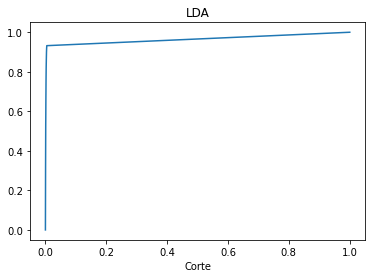

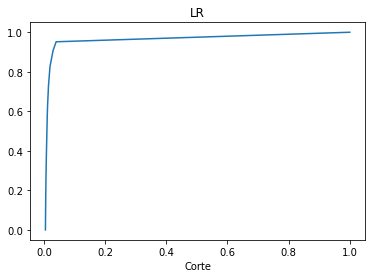

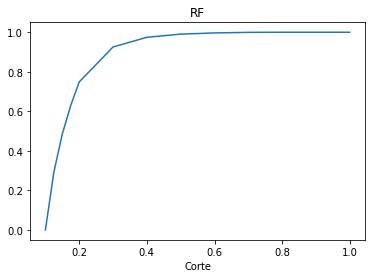

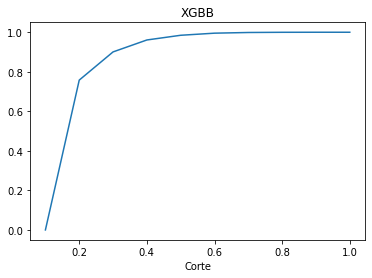

In [202]:
modelos = np.unique(stats_df.index.get_level_values('modelo'))
for modelo in modelos:
    eff = stats_df.loc[modelo].global_efficiency
    eff = (eff - np.min(eff))/(np.max(eff) - np.min(eff))
    co = stats_df.loc[modelo].index.to_numpy()
    plt.plot(co, eff)
    plt.title(modelo)
    #plt.xscale('log')
    plt.xticks()
    #plt.xlim(0, 0.1)
    plt.xlabel('Corte')
    plt.savefig('results/figures/graphs/codos/{}_codo_log.png'.format(modelo), bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

## Optimal graphs

In [198]:
def arg_find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

stats_df.groupby('modelo').apply(lambda x: x.reset_index().iloc[arg_find_nearest(x.per_max_eff, .8)])

,modelo,corte,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,NAME,per_max_eff
modelo,,,,,,,,,,
LDA,LDA,0.00225,177.753728,411085,273.236956,0.822598,4.862086e-05,0.614158,reduced_224.pkl,0.809350
LR,LR,0.00900,26.776187,250866,166.743769,0.831408,-1.264536e-10,0.707343,reduced_899.pkl,0.790499
RF,RF,0.15000,3.376934,623882,414.677301,0.693328,3.566893e-04,0.443948,reduced_15000.pkl,0.788646
XGBB,XGBB,0.20000,2.373301,349511,232.310402,0.611964,1.741794e-03,0.455577,reduced_20000.pkl,0.818252


## Power Law

In [ ]:
stats_total = []
for model in models_paths:
    stats_tmp = stats_by_model(model)
    stats_total = stats_total + stats_tmp
stats_df = pd.DataFrame(stats_total)
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

stats_df.loc[stats_df.pow_degree_p > .1, 'degree_sig'] = ''
stats_df.loc[stats_df.pow_degree_p < .1, 'degree_sig'] = '*'
stats_df.loc[stats_df.pow_degree_p < .05, 'degree_sig'] = '**'
stats_df.loc[stats_df.pow_degree_p < .01, 'degree_sig'] = '***'

stats_df.loc[stats_df.pow_str_p > .1, 'str_sig'] = ''
stats_df.loc[stats_df.pow_str_p < .1, 'str_sig'] = '*'
stats_df.loc[stats_df.pow_str_p < .05, 'str_sig'] = '**'
stats_df.loc[stats_df.pow_str_p < .01, 'str_sig'] = '***'

In [21]:
# Optimal
stats_df[stats_df['per_max_eff'] > .80].groupby('modelo').first()

,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,Assort. degree,per_max_eff,degree_sig,str_sig
modelo,,,,,,,,,,,,,,,,
LinearDiscriminantAnalysis,0.1,218.733709,4495830,2988.255234,3433.082018,2998.0,0.062053,7810.553682,2975.837119,0.010801,0.999675,0.000032,0.026077,0.999998,*,**
LogisticRegression,0.1,24.849282,2303025,1530.757727,391.758003,2251.0,0.986096,360.350586,2128.133390,0.840555,0.932081,0.000052,0.423752,0.997595,,
RandomForestClassifier,0.3,3.068783,1828590,1215.413759,44.945713,1977.0,0.259964,65.289675,1681.341876,0.754877,0.821960,0.001317,0.280315,0.937314,,
best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,0.213521,11.346527,770.011319,0.127554,0.689643,0.049384,0.510320,0.896160,,


## Format table

In [197]:
# Tabla general
# Solo alrededor del corte optimo
# Modelo, submodelo por corte
main_table = stats_df.copy()
main_table.drop(labels='NAME', axis=1, inplace=True)
main_table.drop_duplicates(inplace=True)

styler = main_table.style
styler.format('{:.2f}', subset=['global_efficiency', 'mean_degree'])\
      .format(lambda x: '{:.2f}\%'.format(x*100), subset=['per_max_eff'])\
      .format_index('{:.4f}', level=1)

main_table.rename({'global_efficiency':'Eficiencia global', 
                   'mean_degree':'Grado medio', 
                   'cluster_coeff':'Coef. agrupamiento', 
                   'per_max_eff':'\% Max efi.'}, 
                  axis=1, inplace=True)
styler

In [163]:
tab_latex = styler.to_latex()
print(tab_latex)

\begin{tabular}{llrrrrrrr}
 &  & Eficiencia global & aristas & Grado medio & Coef. agrupamiento & modularity & Assort. degree & \% Max efi. \\
modelo & corte &  &  &  &  &  &  &  \\
\multirow[c]{10}{*}{LDA} & 0.0010 & 119.38 & 116736 & 77.59 & 0.804246 & 0.000000 & 0.639000 & 56.10\% \\
 & 0.0015 & 150.78 & 221763 & 147.40 & 0.828738 & 0.000000 & 0.678622 & 70.85\% \\
 & 0.0020 & 172.30 & 343202 & 228.12 & 0.825626 & 0.000035 & 0.638030 & 80.96\% \\
 & 0.0025 & 184.74 & 482735 & 320.86 & 0.821720 & 0.000054 & 0.589858 & 86.81\% \\
 & 0.0030 & 194.82 & 638574 & 424.44 & 0.828208 & 0.000088 & 0.562200 & 91.54\% \\
 & 0.0035 & 201.73 & 798473 & 530.72 & 0.841179 & 0.000165 & 0.553902 & 94.79\% \\
 & 0.0040 & 205.88 & 955535 & 635.12 & 0.849034 & 0.000234 & 0.523058 & 96.74\% \\
 & 0.0045 & 209.56 & 1112508 & 739.45 & 0.852872 & 0.000293 & 0.488302 & 98.47\% \\
 & 0.0050 & 211.57 & 1272388 & 845.72 & 0.858102 & 0.000344 & 0.464810 & 99.41\% \\
 & 0.0055 & 212.82 & 1435996 & 954.47 & 0.8635